<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [68]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sklearn.tree as sktree

This function is to plot the confusion matrix.


In [5]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [6]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [7]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [8]:
data[["Flights"]].value_counts()

Flights
1          53
2          19
3           8
4           6
5           2
6           2
dtype: int64

In [9]:
data[["LandingPad"]].value_counts()

LandingPad              
5e9e3032383ecb6bb234e7ca    35
5e9e3032383ecb267a34e7c7    13
5e9e3033383ecbb9e534e7cc    12
5e9e3032383ecb554034e7c9     2
5e9e3032383ecb761634e7cb     2
dtype: int64

In [10]:
data[["Block"]].value_counts()

Block
5.0      39
1.0      19
3.0      15
4.0      11
2.0       6
dtype: int64

In [11]:
data[["ReusedCount"]].value_counts()

ReusedCount
0              30
1              24
3              12
5              11
2               9
4               4
dtype: int64

In [12]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [13]:
X.head(5)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 83 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FlightNumber                         90 non-null     float64
 1   PayloadMass                          90 non-null     float64
 2   Flights                              90 non-null     float64
 3   Block                                90 non-null     float64
 4   ReusedCount                          90 non-null     float64
 5   Orbit_ES-L1                          90 non-null     float64
 6   Orbit_GEO                            90 non-null     float64
 7   Orbit_GTO                            90 non-null     float64
 8   Orbit_HEO                            90 non-null     float64
 9   Orbit_ISS                            90 non-null     float64
 10  Orbit_LEO                            90 non-null     float64
 11  Orbit_MEO                         

In [15]:
X.index

RangeIndex(start=0, stop=90, step=1)

In [16]:
X.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount',
       'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS',
       'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO',
       'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A',
       'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7',
       'LandingPad_5e9e3032383ecb554034e7c9',
       'LandingPad_5e9e3032383ecb6bb234e7ca',
       'LandingPad_5e9e3032383ecb761634e7cb',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005',
       'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005',
       'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010',
       'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015',
       'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019',
       'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023',
       'Serial_B1025', 'Serial_B1026', 'Serial_B1028', 'Serial_B102

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [17]:
Y = data["Class"].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [18]:
transform = preprocessing.StandardScaler()
X_scaled = pd.DataFrame(transform.fit_transform(X.values), index = X.index, columns = X.columns)
X = X_scaled.copy()
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,-1.712912,-1.948145e-16,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
1,-1.674419,-1.195232e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
2,-1.635927,-1.162673e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,1.812654,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
3,-1.597434,-1.200587e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
4,-1.558942,-6.286706e-01,-0.653913,-1.575895,-0.97344,-0.106,-0.106,1.527525,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091


We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

we can see we only have 18 test samples.


In [20]:
Y_test.shape

(18,)

In [21]:
X_test.shape

(18, 83)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv = 10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [23]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [24]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

In [25]:
Yhat_test = logreg_cv.predict(X_test)
Yhat_test

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [26]:
Y_test

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

In [27]:
accuracy_score(Y_test, Yhat_test)

0.8333333333333334

Lets look at the confusion matrix:


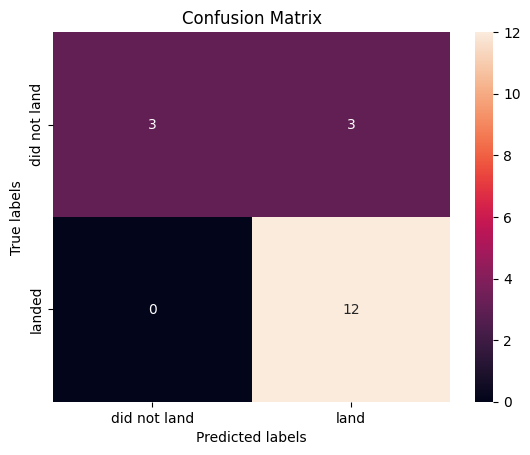

In [28]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [29]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [30]:
svm_cv = GridSearchCV(svm, parameters, cv = 10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [31]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [32]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


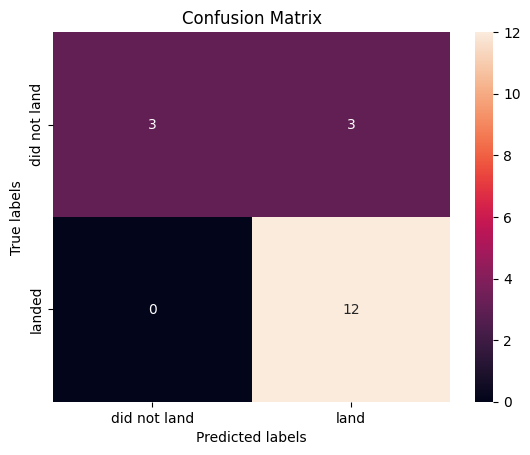

In [33]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [34]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'], #value 'auto' is depricated https://github.com/scikit-learn/scikit-learn/pull/22476
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [35]:
tree_cv = GridSearchCV(tree, parameters, cv = 10, error_score='raise')
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise', estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [36]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [37]:
tree_cv.score(X_test, Y_test)

0.8888888888888888

We can plot the confusion matrix


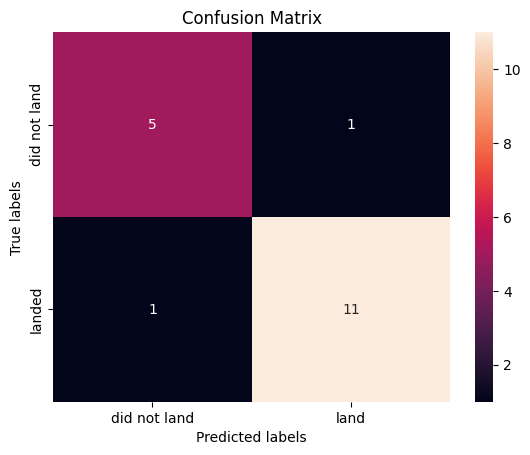

In [38]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [64]:
tree_best = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, splitter = 'best')

In [65]:
tree_best.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6, max_features='sqrt')

In [66]:
tree_best.score(X_test, Y_test)

0.8888888888888888

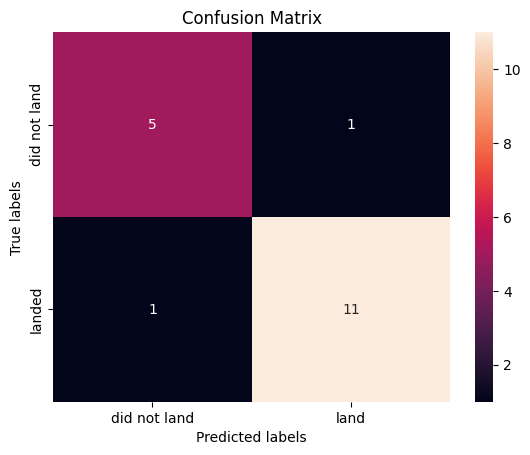

In [67]:
yhat_best = tree_best.predict(X_test)
plot_confusion_matrix(Y_test,yhat_best)

[Text(0.55, 0.9285714285714286, 'x[33] <= 4.664\ngini = 0.444\nsamples = 72\nvalue = [24, 48]'),
 Text(0.48333333333333334, 0.7857142857142857, 'x[3] <= -1.261\ngini = 0.438\nsamples = 71\nvalue = [23, 48]'),
 Text(0.2, 0.6428571428571429, 'x[34] <= 4.664\ngini = 0.426\nsamples = 13\nvalue = [9, 4]'),
 Text(0.13333333333333333, 0.5, 'x[16] <= -0.228\ngini = 0.444\nsamples = 12\nvalue = [8, 4]'),
 Text(0.06666666666666667, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.2, 0.35714285714285715, 'x[31] <= 4.664\ngini = 0.463\nsamples = 11\nvalue = [7, 4]'),
 Text(0.13333333333333333, 0.21428571428571427, 'x[41] <= 4.664\ngini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(0.06666666666666667, 0.07142857142857142, 'gini = 0.346\nsamples = 9\nvalue = [7, 2]'),
 Text(0.2, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.26666666666666666, 0.21428571428571427, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.26666666666666666, 0.5, 'gini = 0.

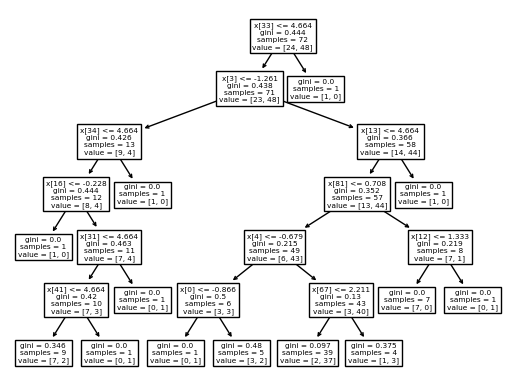

In [69]:
sktree.plot_tree(tree_best)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [39]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [40]:
knn_cv = GridSearchCV(KNN, parameters, cv = 10)
knn_cv.fit(X_train, Y_train)

/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [41]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [42]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


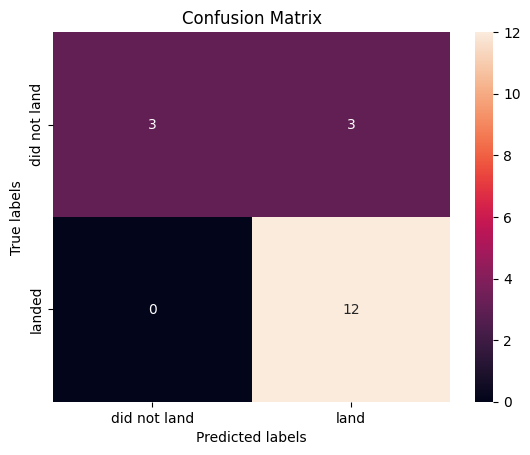

In [43]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


As the decision tree gave the best accuracy on the test data, and it also predicted successful landings more conservatively I would chose this model (as predicting successful landing with unsuccessful landing in reality (being too optimistc) is the outcome we want to avoid in this case, as it costs a lot of money).

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
